# Bitcoin Price Prediction

Bitcoin is seen by many as digital gold. The analogy to gold holds even in the context of thinking about other cryptocurrencies. In the 20th century, we saw the financial death of silver and copper, which are effectively just used as industrial metals at this point and are not great stores of value because they are relatively easy to mine. If BTC is gold, then the other cryptocurrencies are silver and copper. Moneys that are easy to make––whether they are copper or glass beads or beautiful volcanic stones or whatever else humans have used as currency––are not great stores of value. The promise of BTC, which is energetically expensive to "mine" and has a limit on its supply, is one of being a good store of value like gold, but with the ability to transact globally and with final settlement arriving within minutes as opposed to days or weeks.

I don't trade BTC like you might a security. I use it as a store of value. But being able to predict its price based on historical trends still makes me happy. The following notebook is in service of that effort.


***Disclosure: I believe in the promise of Bitcoin and have put some money where my mouth is... that is, into Bitcoin. I am invested in its success and anything positive I say should be viewed with my potential bias in check. I am not providing professional financial advice to anyone here.***

I also highly recommend *The Bitcoin Standard* by Saifedean Ammous. When he sticks to economics, which is his field, Saifedean is incisive and brilliant.

# BTC Data
The BTC price data were downloaded from [Kaggle](https://www.kaggle.com/datasets/gallo33henrique/bitcoin-btc-usd-stock-dataset/data?select=BTC-USD_stock_data.csv) and contain daily stock price data. The dataset is loaded below and columns are shown.

The DataFrame contains:
1. Date
2. Opening Price
3. Highest Price
4. Lowest Price
5. Closing Price
6. Adjusted Closing Price (takes dividends, stock splits, and new stock offerings into account but should not be particularly important for BTC given the nature of BTC as not really a security but a store of value)
7. Volume (overall number of trades within the day)

In [ ]:
# Import data management modules
import pandas as pd
import numpy as np
from datetime import timedelta

# Import data visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import plotly.graph_objects as go

# Import machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random


In [73]:
btc_df = pd.read_csv('BTC-USD_stock_data.csv')

btc_df.Date = pd.to_datetime(btc_df.Date)

# Check for missing values
display(btc_df.info())
display(btc_df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2836 non-null   datetime64[ns]
 1   Open       2836 non-null   float64       
 2   High       2836 non-null   float64       
 3   Low        2836 non-null   float64       
 4   Close      2836 non-null   float64       
 5   Adj Close  2836 non-null   float64       
 6   Volume     2836 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 155.2 KB


None

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Long Short-Term Memory Recurrent Neural Network
Assuming that despite volatility, the general trajectory of BTC will be similar to the types of increase it has seen in the past, LSTM may be a particularly good choice for stock price prediction. Note that past performance does not guarantee future performance and certain assumptions like the one above are inherent to many prediction models.    

## Data Setup

In [75]:
# Set the random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)  # For PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For PyTorch GPU
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU setup
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's random module
    torch.backends.cudnn.deterministic = True  # Ensures reproducibility
    torch.backends.cudnn.benchmark = False     # Ensures reproducibility

# Set the seed at the beginning of your code
answer_to_life = 42
set_seed(answer_to_life)

# Select the closing price for prediction
closing_price = btc_df['Close'].values.reshape(-1, 1)

# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price)

# Define the training data size
train_pct = 0.7
train_size = int(len(scaled_data) * train_pct)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the training data for the LSTM model
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Look at the last month's worth of data to predict the next day's closing price
sequence_length = 60  

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data to 3D for the LSTM model: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Display shapes of the training and testing data
X_train.shape, y_train.shape, X_test.shape, y_test.shape



((1925, 60, 1), (1925,), (791, 60, 1), (791,))

## Visualizing Training Versus Test Data

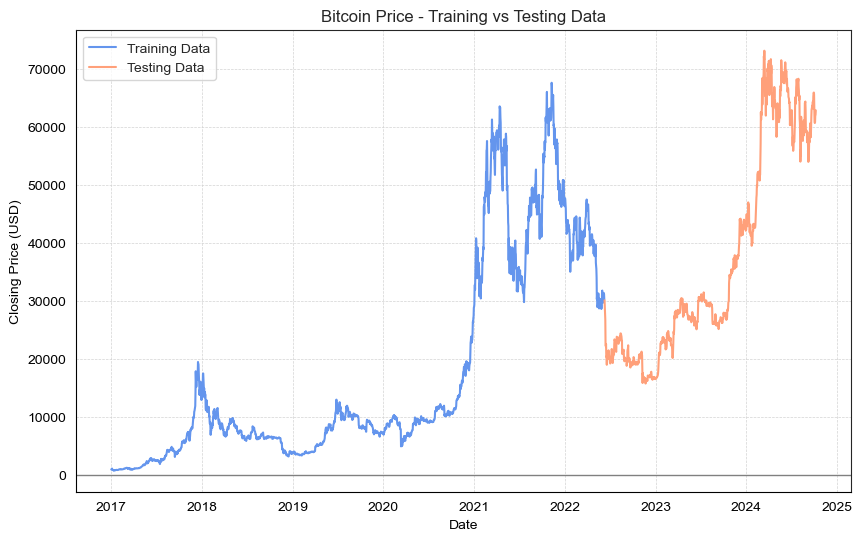

In [86]:
# Extract dates corresponding to the train and test sets
train_dates = btc_df['Date'][:train_size]
test_dates = btc_df['Date'][train_size:]

# Extract closing prices for train and test sets
train_prices = closing_price[:train_size]
test_prices = closing_price[train_size:]

# Create the interactive plot
fig = go.Figure()

# Add training data to the plot
fig.add_trace(go.Scatter(x=train_dates, y=train_prices.flatten(), 
                         mode='lines', name='Training Data',
                         line=dict(color='cornflowerblue')))

# Add testing data to the plot
fig.add_trace(go.Scatter(x=test_dates, y=test_prices.flatten(), 
                         mode='lines', name='Testing Data',
                         line=dict(color='lightsalmon')))

# Customize the layout
fig.update_layout(
    title='Bitcoin Price - Training vs Testing Data',
    xaxis_title='Date',
    yaxis_title='Closing Price (USD)',
    hovermode='x unified',
    plot_bgcolor='white',
    # Customizing axis and grid colors
    xaxis=dict(
        showgrid=True,          # Show gridlines
        gridcolor='lightgray',  # Grid line color
        zeroline=True,          # Show zero line
        zerolinecolor='black',   # Zero line color
        linecolor='black',      # Axis line color
        tickcolor='lightgray',      # Tick color
        tickfont=dict(color='black')  # Tick label color
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=True,
        zerolinecolor='black',
        linecolor='black',
        tickcolor='lightgray',
        tickfont=dict(color='black')
    ),
    paper_bgcolor='white'
)

# Display the interactive plot
fig.show()


# Plot the training and testing data using matplotlib
plt.figure(figsize=(10,6))

# Plot training data
plt.plot(train_dates, train_prices.flatten(), label='Training Data', color='cornflowerblue')

# Plot testing data
plt.plot(test_dates, test_prices.flatten(), label='Testing Data', color='lightsalmon')

# Customize plot
plt.title('Bitcoin Price - Training vs Testing Data')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')

# Add gridlines and zero line
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')  # Add gridlines
plt.axhline(0, color='gray', linewidth=1)  # Zero line

# Add legend
plt.legend()

# Customize axis colors and ticks
ax = plt.gca()  # Get current axis
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')  # X-axis label color
ax.yaxis.label.set_color('black')  # Y-axis label color
ax.tick_params(axis='x', colors='black')  # X-axis tick colors
ax.tick_params(axis='y', colors='black')  # Y-axis tick colors

# Show the plot
plt.show()

Epoch 1/100, Loss: 0.10980547219514847
Epoch 6/100, Loss: 0.06044062599539757
Epoch 11/100, Loss: 0.04246668890118599
Epoch 16/100, Loss: 0.020894993096590042
Epoch 21/100, Loss: 0.00681192334741354
Epoch 26/100, Loss: 0.0037249887827783823
Epoch 31/100, Loss: 0.0026205689646303654
Epoch 36/100, Loss: 0.0019505827222019434
Epoch 41/100, Loss: 0.0014921899419277906
Epoch 46/100, Loss: 0.0012329141609370708
Epoch 51/100, Loss: 0.0011015391210094094
Epoch 56/100, Loss: 0.0009270648006349802
Epoch 61/100, Loss: 0.0008458722149953246
Epoch 66/100, Loss: 0.0008186829509213567
Epoch 71/100, Loss: 0.0007393917767331004
Epoch 76/100, Loss: 0.0007708740304224193
Epoch 81/100, Loss: 0.0007678208057768643
Epoch 86/100, Loss: 0.0007663604337722063
Epoch 91/100, Loss: 0.0007364001940004528
Epoch 96/100, Loss: 0.000756363442633301


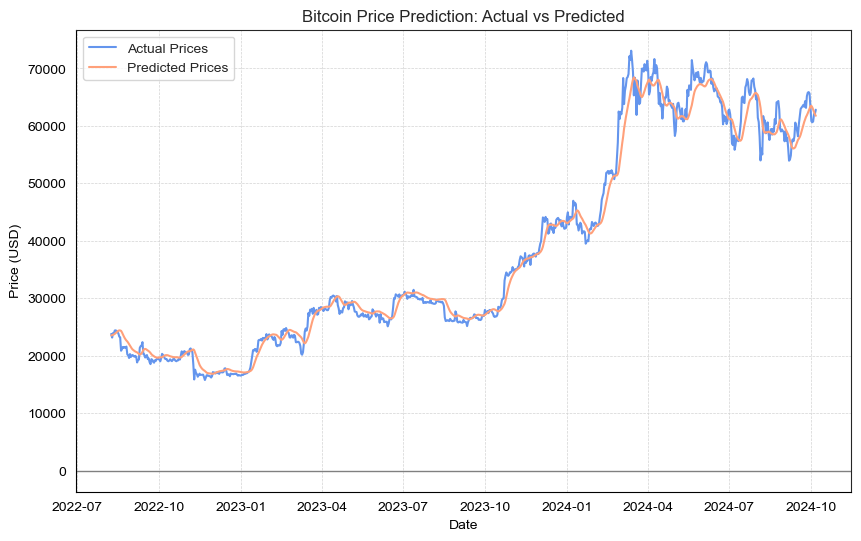

In [15]:
# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1, num_layers=2, dropout_prob=0.05):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob # for dropout regularization to mitigate overfitting

        # LSTM layer with multiple layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=self.num_layers, batch_first=True, dropout=self.dropout_prob)

        # Dropout layer after LSTM layers
        self.dropout = nn.Dropout(p=self.dropout_prob)

        # Linear layer for final output
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state for each layer in the LSTM
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)  # Hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)  # Cell state

        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x, (h_0, c_0))

        # Apply dropout
        lstm_out = self.dropout(lstm_out)

        # Pass the output of the last time step through the linear layer
        predictions = self.linear(lstm_out[:, -1])
        return predictions


# Training parameters
epochs = 100
lr = 0.001

# Initialize the model, loss function, and optimizer
model = BitcoinPriceLSTM()
loss_function = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Ensure target tensor has the correct shape [####, 1]
if y_train_tensor.dim() > 2:  # If there are extra dimensions
    y_train_tensor = y_train_tensor.squeeze()  # Remove extra dimensions
# Add one extra dimension if needed
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)

# Train the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_train_pred = model(X_train_tensor)

    # Calculate loss
    train_loss = loss_function(y_train_pred, y_train_tensor)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss.item()}')

# Test the model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)

# Inverse transform the predicted and actual values back to their original scale
y_test_pred_scaled = scaler.inverse_transform(y_test_pred.numpy().reshape(-1, 1))
y_test_actual_scaled = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

# Adjust test_dates to match the length of y_test_actual_scaled and y_test_pred_scaled
test_dates_adjusted = test_dates[sequence_length:]


# Create the interactive plot with Plotly – for time series predictions, these are great!
fig = go.Figure()

# Add actual price data to the plot
fig.add_trace(go.Scatter(x=test_dates_adjusted, y=y_test_actual_scaled.flatten(),
                         mode='lines', name='Actual Prices', line=dict(color='cornflowerblue')))

# Add predicted price data to the plot
fig.add_trace(go.Scatter(x=test_dates_adjusted, y=y_test_pred_scaled.flatten(),
                         mode='lines', name='Predicted Prices', line=dict(color='lightsalmon')))

# Figure aesthetics
fig.update_layout(
    title='Bitcoin Price Prediction: Actual vs Predicted',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    hovermode='x unified',
    plot_bgcolor='white',
    # Customize axis and grid colors
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=True,
        zerolinecolor='gray',
        linecolor='black',
        tickcolor='lightgray',
        tickfont=dict(color='black')
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=True,
        zerolinecolor='gray',
        linecolor='black',
        tickcolor='lightgray',
        tickfont=dict(color='black')
    ),
    paper_bgcolor='white'
)

# Display interactive plot
fig.show()

# alternative plotting without plotly for easier visualization:
# Plot the predictions vs actual values
plt.figure(figsize=(10,6))

# Plot actual price data
plt.plot(test_dates_adjusted, y_test_actual_scaled.flatten(), label='Actual Prices', color='cornflowerblue')

# Plot predicted price data
plt.plot(test_dates_adjusted, y_test_pred_scaled.flatten(), label='Predicted Prices', color='lightsalmon')

# Customize plot
plt.title('Bitcoin Price Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')  # Add gridlines
plt.axhline(0, color='gray', linewidth=1)  # Zero line

# Add legend
plt.legend()

# Customize the axis colors
ax = plt.gca()  # Get current axis
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.xaxis.label.set_color('black')  # X-axis label color
ax.yaxis.label.set_color('black')  # Y-axis label color
ax.tick_params(axis='x', colors='black')  # X-axis tick colors
ax.tick_params(axis='y', colors='black')  # Y-axis tick colors

# Show the plot
plt.show()
